# A simple MNIST classifier

In this little notebook we will train neural networks on the MNIST dataset. We begin with a simple fully connected network and afterwards compare it to a convolutional neural network. For the latter we look at three different possibilies of changing the network architecture in order to improve model performance. We also do a little bit of error analysis and point at ways to improve the networks though we do not go in these direction at all.

We begin by loading the basic libraries and modules we are going to use. If you wish to train your model on an AMD graphics card, you may want to have a look at plaidml and change the first cell accordingly. Also if you don't want to use tensorboard feel free to delete the respective lines of code using it.

In [1]:
import os
import tensorflow as tf
import tensorflow.keras as keras
import PIL
import numpy as np
import pandas as pd

from IPython.display import Image
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, Dense, MaxPooling2D, Input, Flatten, BatchNormalization, Dropout
import matplotlib.pyplot as plt
from keras.utils import to_categorical

keras.backend.set_image_data_format('channels_last')

%load_ext tensorboard

Using TensorFlow backend.


In [2]:
def one_hot_to_label(pred):
    return np.argmax(pred)

def plot_accuracy(history):
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()
    
def plot_loss(history):
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()

Now, let us load the MNIST dataset. Luckily, it is part of the keras datasets so we can just load it with a simple command.

In [3]:
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

print('Number of training samples: ', x_train.shape[0])
print('Number of test samples: ', x_test.shape[0])

Number of training samples:  60000
Number of test samples:  10000


After loading the dataset, let us have a look at the data we have.

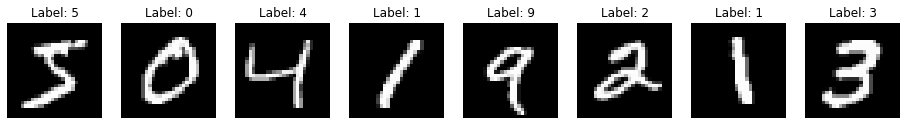

In [4]:
fig, axes = plt.subplots(1, 8, figsize=(16, 2))
for ind, ax in enumerate(axes.flat):
    ax.set_axis_off()
    ax.imshow(x_train[ind], cmap=plt.get_cmap('gray'))
    ax.set_title('Label: ' + str(y_train[ind]))

Ok, so these are pictures of handwritten images, each 28x28 pixels and with greyscale values.

## Data preprocessing

There isn't much data preprocessing necessary for this dataset. But converting the pixel values to numbers between 0 and 1 is definitely something we can do easily and which speeds up training quite a bit. So let us do so.

In [5]:
def preprocess_data(x, y):
    x = x.astype('float32')
    x = x.reshape((x.shape[0], 28, 28, 1)) # add extra dimension to use conv2d in the model
    x = x/255 # normalize to values between 0 and 1
    
    y = to_categorical(y) # one hot encoding
    return x, y
    

In [6]:
x_train, y_train = preprocess_data(x_train, y_train)
x_test, y_test = preprocess_data(x_test, y_test)

## Fully connected model

Let us start by defining a fully connected network as first model. We take the input image (28x28x1), flatten it into a fully connected layer of size 28\*28=784 and then reduce its size by a factor of four in each step.

In [7]:
def fully_connected_model(input_shape, name='MNIST_fully_connected'):
    
    X_input = Input(input_shape)
    X = X_input
    
    X = Flatten()(X) # fully connected layer with 784 nodes
    
    # reduce by factor of four in each layer
    X = Dense(512, activation='relu')(X)
    X = Dense(128, activation='relu')(X)
    X = Dense(32, activation='relu')(X)
    X = Dense(10, activation='softmax')(X)

    model = Model(X_input, X, name=name)
    
    return model
    
fully_connected_model = fully_connected_model((28, 28, 1))
print(fully_connected_model.summary())

Model: "MNIST_fully_connected"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 512)               401920    
_________________________________________________________________
dense_1 (Dense)              (None, 128)               65664     
_________________________________________________________________
dense_2 (Dense)              (None, 32)                4128      
_________________________________________________________________
dense_3 (Dense)              (None, 10)                330       
Total params: 472,042
Trainable params: 472,042
Non-trainable params: 0
_______________________________________

Alright, so we have 472,042 parameters and four hidden layers. Let's see how well our model performs after some training!

## Training and Evaluation

In [8]:
fully_connected_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [9]:
%tensorboard --logdir ./logs/fully_connected_model/
history = fully_connected_model.fit(x_train, y_train, batch_size=128, epochs=15, validation_split=0.16, shuffle=True, 
                    callbacks=[tf.keras.callbacks.TensorBoard(log_dir='./logs/fully_connected_model/')])
score = fully_connected_model.evaluate(x_test, y_test)

fully_connexted_model.save('./models/')

Reusing TensorBoard on port 6013 (pid 5720), started 17:32:11 ago. (Use '!kill 5720' to kill it.)

Epoch 1/15
  1/394 [..............................] - ETA: 0s - loss: 2.3075 - accuracy: 0.1016WARNING:tensorflow:From /Users/heckel/opt/anaconda3/envs/MNIST/lib/python3.6/site-packages/tensorflow/python/ops/summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
394/394 [==============================] - 2s 4ms/step - loss: 0.2860 - accuracy: 0.9152 - val_loss: 0.1519 - val_accuracy: 0.9545
Epoch 2/15
394/394 [==============================] - 1s 4ms/step - loss: 0.1025 - accuracy: 0.9685 - val_loss: 0.0990 - val_accuracy: 0.9702
Epoch 3/15
394/394 [==============================] - 1s 4ms/step - loss: 0.0648 - accuracy: 0.9804 - val_loss: 0.0866 - val_accuracy: 0.9730
Epoch 4/15
394/394 [==============================] - 1s 4ms/step - loss: 0.0454 - accuracy: 0.9858 - val_loss: 0.0795 - val_accuracy: 0.9760
Epoch 5/15
394/394 [======================

NameError: name 'fully_connexted_model' is not defined

So how does our model perform? Let's have a look at the graphs and scores (if you are using tensorboard, you have seen the graphs already).

In [ ]:
plot_accuracy(history)
plot_loss(history)

In [ ]:
print('Accuracy on train set: ', history.history['accuracy'][-1])
print('Accuracy on test set: ', score[-1])

We have 98.2% accuracy on the test set which is already quite good. On the train set we achieve 99.5% accuracy which is much more. So our model seems to overfit the training set!

Let us have a brief look at examples the model was not predicting correctly.

In [ ]:
def plot_incorrect_preds(model):
    pred = model.predict(x_test)
    pred_labels = np.argmax(pred, axis=1)
    true_labels = np.argmax(y_test, axis=1)

    incorrect = np.where(pred_labels != true_labels)[0]
    print('Number of wrong predictions: ', len(incorrect))
    
    fig, axes = plt.subplots(1, 8, figsize=(16, 2))
    for ind, ax in enumerate(axes.flat):
        ind = incorrect[ind]
        ax.set_axis_off()
        ax.imshow(x_test[ind], cmap=plt.get_cmap('gray'))
        true_label = one_hot_to_label(y_test[ind])
        predicted_label = one_hot_to_label(pred[ind])
        confidence = pred[ind, predicted_label]
        ax.set_title('Label: %s\nPrediction: %s\nConfidence %1.2f' %(true_label, predicted_label, confidence))
        
plot_incorrect_preds(fully_connected_model)

This shows 176 wrong predictions in total. At least among our examples, some of them even have a very high confidence.
Let us try to see if we can discover some systematic error in our models prediction. To to so, we plot predictions versus ground truth and inicate the number of samples at a point (truth, prediction) by its color itensity.

In [ ]:
def plot_preds_scatter(model):
    pred = model.predict(x_test)
    pred_labels = np.argmax(pred, axis=1)
    true_labels = np.argmax(y_test, axis=1)
    
    df = pd.DataFrame(true_labels, columns=['Truth'])
    df['Prediction'] = pred_labels
    df['Incorrect'] = np.where(df['Truth'] == df['Prediction'], False, True)
    df_incorr = df.loc[df.Incorrect].reset_index(drop=True)
    
    df_incorr.plot(x='Truth', y='Prediction', kind='scatter', alpha=.1, s=50, title='')
    
plot_preds_scatter(fully_connected_model)

This reveals, for example, that a two is often mistaken for an eight by the model, a three for a five, and also a nine for a five. We may also have a look at how often number are predicted incorrectly and how many incorrect predictions are there per number.

In [ ]:
def plot_incorr_preds_hist(model):
    pred = model.predict(x_test)
    pred_labels = np.argmax(pred, axis=1)
    true_labels = np.argmax(y_test, axis=1)
    
    df = pd.DataFrame(true_labels, columns=['Truth'])
    df['Prediction'] = pred_labels
    df['Incorrect'] = np.where(df['Truth'] == df['Prediction'], False, True)
    df_incorr = df.loc[df.Incorrect].reset_index(drop=True)
    
    df_incorr.hist(column=['Truth', 'Prediction'], figsize=(16, 4), grid=False)

plot_incorr_preds_hist(fully_connected_model)

The numbers three and nine are seen to cause most of the mispredictions but the model also isn't doing too well on three, seven and eight. If a seven is predicted, this is more often false than for other numbers.

## A convolutional model

For computer vision tasks (as recognizing digits in images) convolutional networks usually perform better as it is possible for them to learn patterns. So let us set up a new model with one convolutional layer followed by dense layers, reducing the the size by four in each step, just as before.

In [ ]:
def conv_model(input_shape, name='Convolutional_MNIST_model'):
    
    X_input = Input(input_shape)
    X = X_input
    
    X = Conv2D(32, (4, 4), strides=2)(X)
    X = MaxPooling2D(pool_size=(2, 2), strides=2, padding='same')(X)
    
    X = Flatten()(X)
    X = Dense(1024, activation='relu')(X)
    X = Dense(256, activation='relu')(X)
    X = Dense(64, activation='relu')(X)
    X = Dense(10, activation='softmax')(X)
    
    
    
    model = Model(X_input, X, name=name)
    
    return model
    
conv_model = conv_model((28, 28, 1))
print(conv_model.summary())

Now let's train this model.

In [ ]:
conv_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
%tensorboard --logdir ./logs/conv_model/
    
history = conv_model.fit(x_train, y_train, batch_size=128, epochs=15, validation_split=0.16, shuffle=True,
                               callbacks=[tf.keras.callbacks.TensorBoard(log_dir='./logs/conv_model/')])
score = conv_model.evaluate(x_test, y_test)

conv_model.save('./models/')

In [ ]:
print('Accuracy on train set: ', history.history['accuracy'][-1])
print('Accuracy on test set: ', score[-1])

In [ ]:
plot_loss(history)
plot_accuracy(history)

The convolutional model performs a little better on the test set but also clearly overfits the train set. One possibility to reduce overfitting that usually works is to add dropout layers.

### Adding dropout layers

The following model is basically the same as before but containing three dropout layers. 

In [ ]:
def conv_model_with_dropout(input_shape, name='Convolutional_MNIST_model_with_dropout'):
    
    X_input = Input(input_shape)
    X = X_input
    
    X = Conv2D(32, (4, 4), strides=2, activation='relu')(X)
    X = MaxPooling2D(pool_size=(2, 2), strides=2, padding='same')(X)
    X = Dropout(0.4)(X)
    
    X = Flatten()(X)
    X = Dense(1024, activation='relu')(X)
    X = Dropout(0.2)(X)
    X = Dense(256, activation='relu')(X)
    X = Dense(64, activation='relu')(X)
    X = Dropout(0.2)(X)
    X = Dense(10, activation='softmax')(X)
    
    model = Model(X_input, X, name=name)
    
    return model
    
conv_model_with_dropout = conv_model_with_dropout((28, 28, 1))
print(conv_model_with_dropout.summary())

In [ ]:
conv_model_with_dropout.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

%tensorboard --logdir ./logs/conv_model_with_dropout/
    
history = conv_model_with_dropout.fit(x_train, y_train, batch_size=128, epochs=10, validation_split=0.16, 
                                      shuffle=True,
                                      callbacks=[tf.keras.callbacks.TensorBoard(log_dir='./logs/conv_model_with_dropout/')])
score = conv_model_with_dropout.evaluate(x_test, y_test)

conv_model_with_dropout.save('./models/')

In [ ]:
print('Accuracy on train set: ', history.history['accuracy'][-1])
print('Accuracy on test set: ', score[-1])

Our model is doing well on the train set and even a little better on the test set. The difference in performance on both is quite small so we can say that we successfully reduced overfitting of our model. We may look again at mislabelled examples and do our short error analysis as we did for the fully connected model.

In [ ]:
plot_incorrect_preds(conv_model_with_dropout)

In [ ]:
plot_preds_scatter(conv_model_with_dropout)

The biggest issues seem to be that a nine is oftentimes predicted as four and a two as seven. Let's see if the histograms confirm this.

In [ ]:
plot_incorr_preds_hist(conv_model_with_dropout)

They definetely do! So for improving this model it could be a good idea to train it more images of nine and two which we can easily get data agumentation techniques.

## Adding batch normalization

Batch normalization is also a quick way to improve model performance. Let us see if it can help our previous model to perform even better.

In [ ]:
def conv_model_dropout_batchnorm(input_shape, name='Convolutional_MNIST_model_with_dropout_and_batch_normalization'):
    
    X_input = Input(input_shape)
    X = X_input
    
    X = BatchNormalization()(X)
    X = Conv2D(32, (4, 4), strides=2, activation='relu')(X)
    X = MaxPooling2D(pool_size=(2, 2), strides=2, padding='same')(X)
    X = Dropout(0.4)(X)
    
    X = BatchNormalization()(X)
    X = Flatten()(X)
    X = Dense(1024, activation='relu')(X)
    X = Dropout(0.2)(X)
    X = Dense(256, activation='relu')(X)
    X = BatchNormalization()(X)
    X = Dense(64, activation='relu')(X)
    X = Dropout(0.2)(X)
    X = Dense(10, activation='softmax')(X)
    
    
    
    model = Model(X_input, X, name=name)
    
    return model
    
conv_model_dropout_batchnorm = conv_model_dropout_batchnorm((28, 28, 1))
print(conv_model_dropout_batchnorm.summary())

In [ ]:
conv_model_dropout_batchnorm.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

%tensorboard --logdir ./logs/conv_model_dropout_batchnorm/
    
history = conv_model_dropout_batchnorm.fit(x_train, y_train, batch_size=128, epochs=15, validation_split=0.16, 
                                          shuffle=True,
                                          callbacks=[tf.keras.callbacks.TensorBoard(log_dir='./logs/conv_model_dropout_batchnorm/')])
score = conv_model_dropout_batchnorm.evaluate(x_test, y_test)

conv_model_dropout_batchnorm.save('./models/')

In [ ]:
print('Accuracy on train set: ', history.history['accuracy'][-1])
print('Accuracy on test set: ', score[-1])

There is almost no performance improvement, instead our model tends more to overfit the training data. Thus, batch normalization doesn't seem to be helpful here.

## A deep convolutional network

As introducing a single convolutional layer worked out well, let us see how things are if we add many convolutional layer and try to learn the digit classification with a deep convolutional network. We will continue using dropout to prevent overfitting.

In [ ]:
def deep_conv_model(input_shape, name='Deep_convolutional_MNIST_model'):
    
    X_input = Input(input_shape)
    X = X_input
    
    X = Conv2D(8, (4, 4), activation='relu', padding='same')(X)
    X = Conv2D(8, (1, 1), activation='relu')(X)
    X = MaxPooling2D(pool_size=(2, 2), strides=2, padding='same')(X)
    X = Conv2D(16, (4, 4), activation='relu', padding='same')(X)
    X = Conv2D(16, (1, 1), activation='relu')(X)
    X = Conv2D(32, (4, 4), strides=2, activation='relu', padding='same')(X)
    X = Conv2D(32, (1, 1), activation='relu')(X)
    X = Conv2D(64, (4, 4), strides=2, activation='relu', padding='same')(X)
    X = Conv2D(64, (1, 1), activation='relu')(X)
    X = Dropout(0.4)(X)
    X = Conv2D(128, (4, 4), strides=2, activation='relu')(X)
    X = Conv2D(128, (1, 1), activation='relu')(X)
    X = Dropout(0.4)(X)
    
    X = Flatten()(X)
    X = Dense(64, activation='relu')(X)
    X = Dense(32, activation='relu')(X)
    X = Dense(16, activation='relu')(X)
    X = Dropout(0.2)(X)
    X = Dense(10, activation='softmax')(X)
    
    
    
    model = Model(X_input, X, name=name)
    
    return model
    
deep_conv_model = deep_conv_model((28, 28, 1))
print(deep_conv_model.summary())

Note that altough this is a deep model, it has much fewer parameters than our previous model.

In [ ]:
deep_conv_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

%tensorboard --logdir ./logs/deep_conv_model/
    
history = deep_conv_model.fit(x_train, y_train, batch_size=128, epochs=15, validation_split=0.16, shuffle=True,
                              callbacks=[tf.keras.callbacks.TensorBoard(log_dir='./logs/deep_conv_model/')])
score = deep_conv_model.evaluate(x_test, y_test)

deep_conv_model.save('./models/')

In [ ]:
print('Accuracy on train set: ', history.history['accuracy'][-1])
print('Accuracy on test set: ', score[-1])

This is 99% percent accuracy and the best we had so far.

In [ ]:
plot_incorrect_preds(deep_conv_model)

In [ ]:
plot_preds_scatter(deep_conv_model)

In [ ]:
plot_incorr_preds_hist(deep_conv_model)

We reached 99% percent accuracy without any data augmentation or advanced techniques and also have shown some ways how the model could be improved. 99% success is quite a success for a model on the MNIST dataset, in particular for networks without any fine-tuning or extensive data preprocessing.